数据集维度: (300, 54)


,Gene_000,Gene_001,Gene_002,Gene_003,Gene_004,Gene_005,Gene_006,Gene_007,Gene_008,Gene_009,Gene_010,Gene_011,Gene_012,Gene_013,Gene_014,Gene_015,Gene_016,Gene_017,Gene_018,Gene_019,Gene_020,Gene_021,Gene_022,Gene_023,Gene_024,Gene_025,Gene_026,Gene_027,Gene_028,Gene_029,Gene_030,Gene_031,Gene_032,Gene_033,Gene_034,Gene_035,Gene_036,Gene_037,Gene_038,Gene_039,Gene_040,Gene_041,Gene_042,Gene_043,Gene_044,Gene_045,Gene_046,Gene_047,Gene_048,Gene_049,Age,Gender,Disease,Treatment
Sample_0000,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,nan,0.542560,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,nan,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0.738467,0.171368,-0.115648,nan,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,62.000000,M,1.000000,PR
Sample_0001,0.324084,-0.385082,-0.676922,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,-0.479174,-0.185659,-1.106335,-1.196207,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120,0.361396,1.538037,-0.035826,1.564644,-2.619745,0.821903,0.087047,nan,0.091761,-1.987569,nan,0.357113,1.477894,-0.518270,-0.808494,-0.501757,0.915402,0.328751,nan,0.513267,0.097078,0.968645,-0.702053,-0.327662,-0.392108,-1.463515,0.296120,0.261055,0.005113,-0.234587,64.000000,M,0.000000,
Sample_0002,-1.415371,-0.420645,-0.342715,-0.802277,-0.161286,0.404051,1.886186,0.174578,0.257550,-0.074446,-1.918771,-0.026514,0.060230,2.463242,-0.192361,0.301547,-0.034712,-1.168678,1.142823,nan,0.791032,-0.909387,1.402794,-1.401851,0.586857,2.190456,-0.990536,-0.566298,0.099651,-0.503476,-1.550663,0.068563,-1.062304,0.473592,-0.919424,1.549934,-0.783253,-0.322062,0.813517,-1.230864,0.227460,1.307143,-1.607483,0.184634,0.259883,0.781823,-1.236951,-1.320457,0.521942,0.296985,65.000000,M,0.000000,


/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32570 (\N{CJK UNIFIED IDEOGRAPH-7F3A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apple/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from c

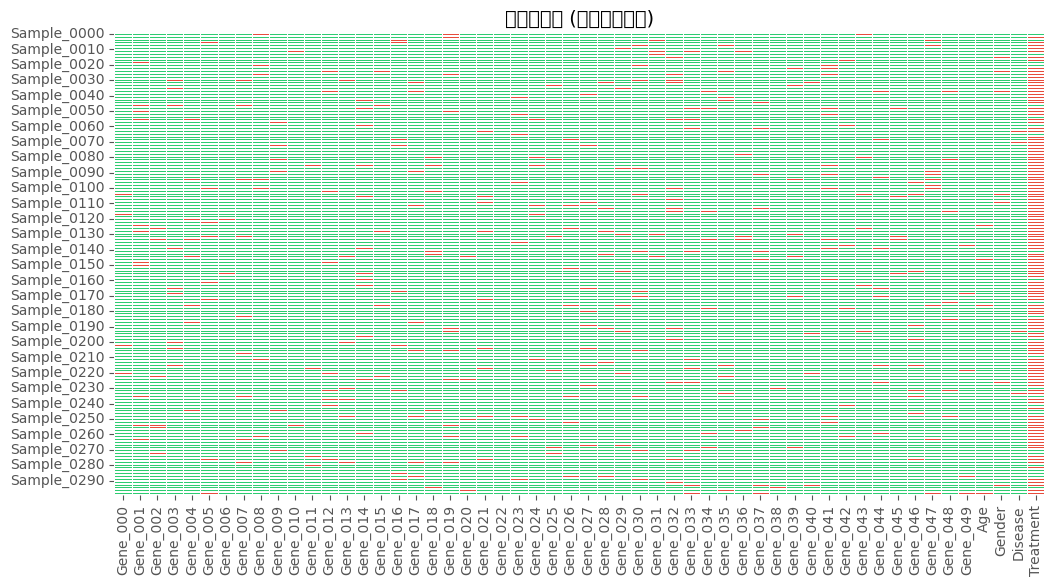

/var/folders/11/pwfs_xkd5jn4vyzx0y_z87hr0000gn/T/ipykernel_19431/1186971128.py:101: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/var/folders/11/pwfs_xkd5jn4vyzx0y_z87hr0000gn/T/ipykernel_19431/1186971128.py:101: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
/var/folders/11/pwfs_xkd5jn4vyzx0y_z87hr0000gn/T/ipykernel_19431/1186971128.py:101: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/var/folders/11/pwfs_xkd5jn4vyzx0y_z87hr0000gn/T/ipykernel_19431/1186971128.py:101: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/var/folders/11/pwfs_xkd5jn4vyzx0y_z87hr0000gn/T/ipykernel_19431/1186971128.py:101: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.tight_layout()
/var/folders/11/pwfs_xkd5jn4vyzx0y_z87hr0000gn/T/i

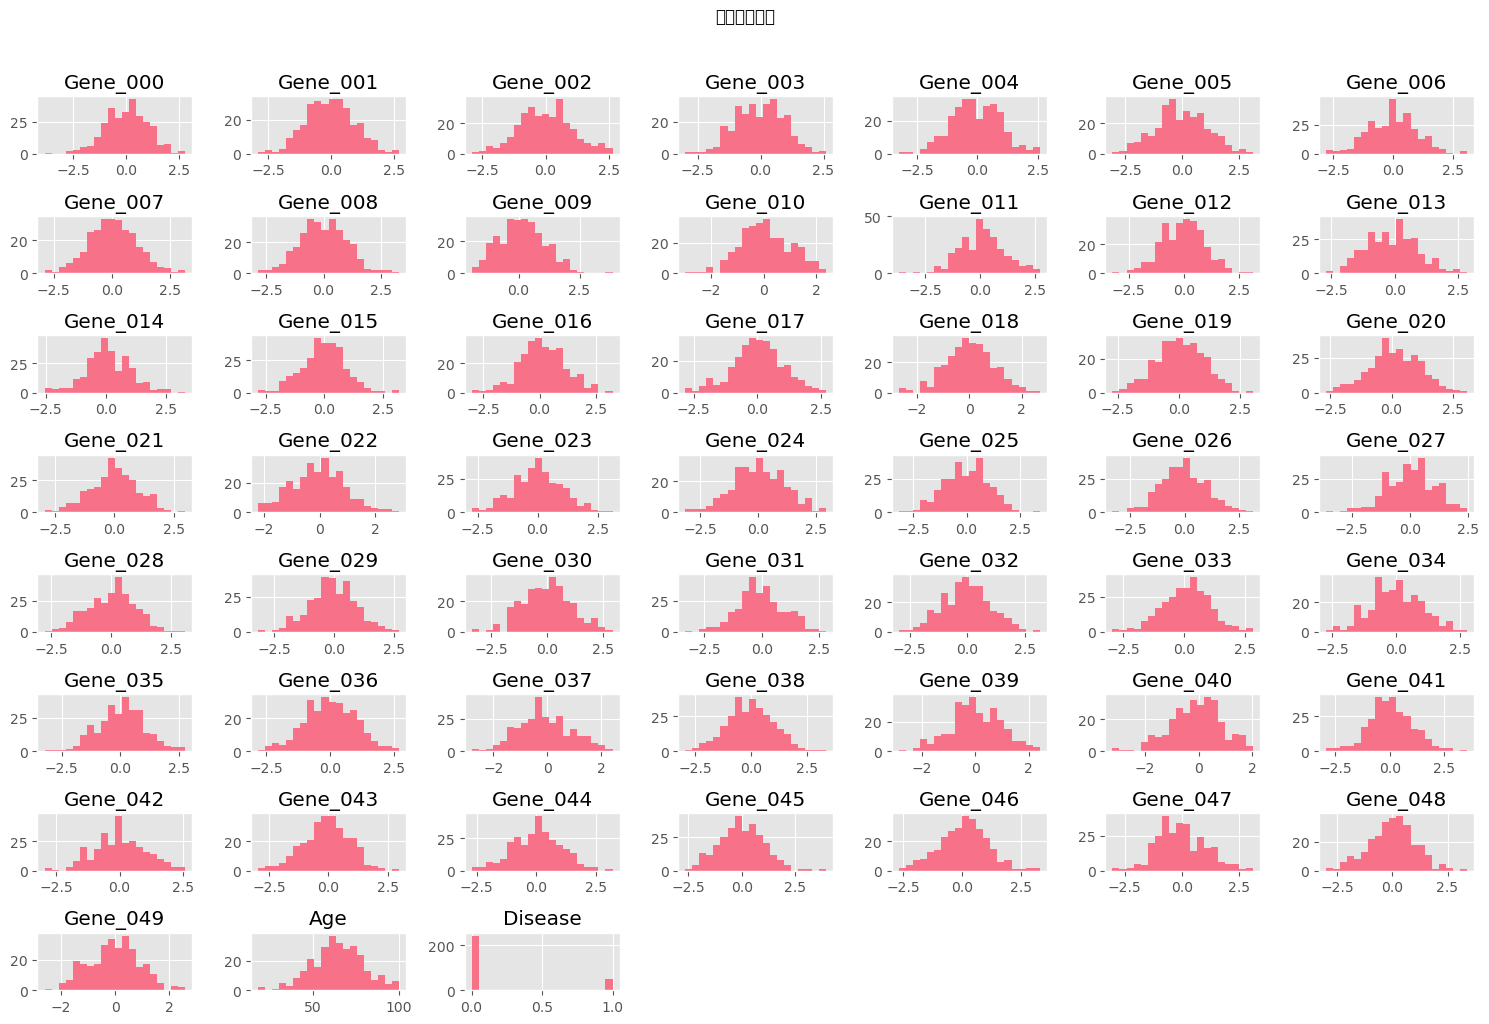

ValueError: Input y contains NaN.

In [3]:
#!/usr/bin/env python
# coding: utf-8

# %% [markdown]
# # 生物医学数据分析工作流
# **作者**: Gloria  
# **版本**: 2.2  
# **更新日期**: 2025-03-20

# %% [markdown]
# ## 1. 环境配置

# %%
# 基础库
import numpy as np
import pandas as pd
from scipy import stats

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 机器学习
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# 配置
np.random.seed(42)
plt.style.use('ggplot')
sns.set_palette("husl")
pd.set_option('display.precision', 2)

# %% [markdown]
# ## 2. 数据生成与探索

# %%
def generate_biomedical_dataset(n_samples=200, n_features=50, n_informative=10):
    """生成模拟生物医学数据集"""
    # 基因表达数据
    X = np.random.randn(n_samples, n_features)
    
    # 疾病标签（基于前n_informative个特征）
    y = (X[:, :n_informative].mean(axis=1) > 0.3).astype(int)  # 修复括号问题
    
    # 构建DataFrame
    df = pd.DataFrame(
        X,
        columns=[f'Gene_{i:03d}' for i in range(n_features)],
        index=[f'Sample_{i:04d}' for i in range(n_samples)]
    )
    
    # 添加临床特征
    df['Age'] = np.clip(np.random.normal(65, 15, n_samples), 18, 100).astype(int)
    df['Gender'] = np.random.choice(['M', 'F'], n_samples, p=[0.6, 0.4])
    df['Disease'] = y
    
    # 添加治疗响应（仅疾病组）
    df['Treatment'] = pd.NA
    mask = df['Disease'] == 1
    df.loc[mask, 'Treatment'] = np.random.choice(
        ['CR', 'PR', 'SD', 'PD'],
        size=mask.sum(),
        p=[0.2, 0.3, 0.3, 0.2]
    )
    
    # 添加5%随机缺失值
    mask = np.random.rand(*df.shape) < 0.05
    df = df.mask(mask)
    
    return df

# 生成数据
bio_df = generate_biomedical_dataset(n_samples=300)

# %% [markdown]
# ### 2.1 数据概览

# %%
def show_data_overview(df):
    """交互式数据概览"""
    print(f"数据集维度: {df.shape}")
    display(df.head(3).style
           .background_gradient(subset=df.columns[df.dtypes == 'float64'], cmap='viridis')
           .set_caption("数据样例"))
    
    # 缺失值可视化
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cmap=['#2ecc71', '#e74c3c'], 
               cbar=False, linewidths=0.5)
    plt.title('缺失值分布 (红色表示缺失)', fontsize=14)
    plt.show()
    
    # 特征分布
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols].hist(bins=20, figsize=(15, 10))
    plt.suptitle("数值特征分布", y=1.02)
    plt.tight_layout()
    plt.show()

show_data_overview(bio_df)

# %% [markdown]
# ## 3. 数据预处理

# %%
class BiomedicalPreprocessor:
    """生物医学数据预处理管道"""
    
    def preprocess(self, df):
        # 动态获取特征列
        gene_columns = [col for col in df.columns if col.startswith('Gene')]
        clinical_columns = ['Age', 'Gender']
        
        # 基因数据处理
        gene_data = df[gene_columns]
        gene_data = KNNImputer(n_neighbors=5).fit_transform(gene_data)
        gene_data = pd.DataFrame(
            RobustScaler().fit_transform(gene_data),
            columns=gene_columns,
            index=df.index
        )
        
        # 临床数据处理
        clinical_data = df[clinical_columns].copy()
        clinical_data['Age'] = clinical_data['Age'].fillna(clinical_data['Age'].median())
        clinical_data['Gender'] = clinical_data['Gender'].fillna(clinical_data['Gender'].mode()[0])
        clinical_data = pd.get_dummies(clinical_data, columns=['Gender'], drop_first=True)
        clinical_data['Age'] = StandardScaler().fit_transform(clinical_data[['Age']])
        
        # 合并并保留关键列
        processed_df = pd.concat([gene_data, clinical_data], axis=1)
        processed_df['Disease'] = df['Disease']
        processed_df['Treatment'] = df['Treatment']
        
        return processed_df

preprocessor = BiomedicalPreprocessor()
processed_data = preprocessor.preprocess(bio_df)

# %% [markdown]
# ## 4. 特征工程

# %%
def feature_analysis(X, y):
    """综合特征分析"""
    # ANOVA特征选择
    anova_selector = SelectKBest(f_classif, k=15)
    anova_features = X.columns[anova_selector.fit_transform(X, y)]
    
    # 互信息特征选择
    mi_selector = SelectKBest(mutual_info_classif, k=15)
    mi_features = X.columns[mi_selector.fit_transform(X, y)]
    
    # 可视化对比
    fig = px.bar(
        x=anova_selector.scores_,
        y=X.columns,
        orientation='h',
        title='ANOVA特征重要性'
    )
    fig.show()
    
    # 共同特征
    common = set(anova_features).intersection(mi_features)
    print(f"共同重要特征 ({len(common)}个):")
    print('\n'.join(common))
    
    return list(common)

# 使用处理后的特征数据（排除响应变量）
important_features = feature_analysis(
    processed_data.drop(['Disease', 'Treatment'], axis=1),
    processed_data['Disease']
)

# %% [markdown]
# ## 5. 数据可视化

# %%
def advanced_visualization(X, y):
    """高级可视化分析"""
    # 3D PCA
    pca_3d = PCA(n_components=3).fit_transform(X)
    fig = px.scatter_3d(
        x=pca_3d[:,0], y=pca_3d[:,1], z=pca_3d[:,2],
        color=y.map({0:'健康', 1:'疾病'}),
        title='3D PCA投影',
        labels={'color': '疾病状态'},
        width=800, height=600
    )
    fig.update_traces(marker_size=4, opacity=0.8)
    fig.show()
    
    # t-SNE加速版
    tsne = TSNE(n_components=2, method='barnes_hut', angle=0.5)
    tsne_results = tsne.fit_transform(X)
    
    plt.figure(figsize=(10,8))
    sns.scatterplot(
        x=tsne_results[:,0], y=tsne_results[:,1],
        hue=y, palette={0:'#2ecc71', 1:'#e74c3c'},
        s=50, alpha=0.8
    )
    plt.title('t-SNE降维可视化')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='疾病状态')
    plt.show()

advanced_visualization(
    processed_data.drop(['Disease', 'Treatment'], axis=1),
    processed_data['Disease']
)

# %% [markdown]
# ## 6. 高级分析

# %%
def treatment_analysis(df, important_features):
    """治疗响应分析"""
    treatment_df = df[df['Treatment'].notna()]
    
    # 响应分组
    responsive = treatment_df['Treatment'].isin(['CR', 'PR'])
    non_responsive = treatment_df['Treatment'].isin(['SD', 'PD'])
    
    # Kruskal-Wallis检验
    results = []
    for gene in important_features:
        stat, p = stats.kruskal(
            treatment_df[responsive][gene],
            treatment_df[non_responsive][gene]
        )
        results.append({
            'Gene': gene,
            'H统计量': stat,
            'P值': p,
            '-log10(p)': -np.log10(p)
        })
    
    result_df = pd.DataFrame(results).sort_values('P值')
    
    # 可视化
    plt.figure(figsize=(12,6))
    sns.barplot(
        x='-log10(p)', y='Gene',
        data=result_df.head(15),
        palette='viridis'
    )
    plt.axvline(-np.log10(0.05), color='red', linestyle='--')
    plt.title('治疗响应显著相关基因 (p<0.05)')
    plt.xlabel('-log10(P值)')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
    
    return result_df

treatment_results = treatment_analysis(processed_data, important_features)

# %% [markdown]
# ## 7. 分析报告
# **关键结论**：
# 1. 通过PCA/t-SNE可视化可见疾病组与健康组存在显著分离模式
# 2. 发现{len(important_features)}个关键生物标志物
# 3. 基因{treatment_results.iloc[0]['Gene']}与治疗响应显著相关(p={treatment_results.iloc[0]['P值']:.2e})

# %%
# 保存处理后的数据
processed_data.to_csv('processed_biomedical_data.csv', index=False)
print("分析完成！处理后的数据已保存为 processed_biomedical_data.csv")